# Cluster data into CSLs

Using the trained `condVAE_pert-CC` model, this tutorial looks at how to cluster the learned latent representation into CSLs.
In order to ensure that the clusters and their annotations are reproducible, we will use a pretrained model in this example. You can also use the model that you trained in the [Train and evaluate models tutorial](train.ipynb), but due to the randomness of training neural networks, the latent space will likely be different, resulting in different clusters.

In this tutorial we will:

- create and cluster a smaller subset of the large dataset
- interactively cluster and annotation the data and plot the results on example cells 
- prepare the entire dataset for clustering
- project the clustering to the entire dataset

In [1]:
import os

from IPython.display import display
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from campa.pl import annotate_img
from campa.tl import (
    Cluster,
    Experiment,
    create_cluster_data,
    get_clustered_cells,
    load_full_data_dict,
    prepare_full_dataset,
    project_cluster_data,
    add_clustering_to_adata,
)
from campa.data import MPPData, load_example_data, load_example_experiment
from campa.utils import init_logging
from campa.constants import campa_config

# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# ensure that example data is downloaded
load_example_data()
# read correct campa_config -- created with setup.ipynb
campa_config.config_fname = "params/campa.ini"
print(campa_config)

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plotting' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


Reading config from params/campa.ini
CAMPAConfig (fname: params/campa.ini)
EXPERIMENT_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments
BASE_DATA_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/raw
CO_OCC_CHUNK_SIZE: 10000000.0
data_config/nascentrna: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_ana/NascentRNA_constants.py
data_config/testdata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/tests/_data/TestData_constants.py
data_config/exampledata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/params/ExampleData_constants.py



First, we need to download the pretrained model

In [2]:
example_experiment_folder = load_example_experiment()
print("Example experiment downloaded to:", example_experiment_folder)

Example experiment downloaded to: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained


## Prepare a subset of the data
First, the the data is subsampled, because we would like the clustering to be interactive and feasible to compute on a laptop. 
If you have more time or access to GPUs, you could also consider to skip the subsampling step and cluster all data directly.

Sub-setting and clustering the data can be done with the high-level API, using [create_cluster_data][].
Alternatively, the CLI can be used:
```
campa cluster test/CondVAE_pred-CC create --subsample --frac 0.1 --save-dir aggregated/sub-0.1 --cluster
```

If you would like to also directly cluster the data, use `cluster=True` in the call to [create_cluster_data][]. Here, we leave the clustering for the interactive clustering and annotation step below.

[create_cluster_data]: ../api/campa.tl.create_cluster_data.rst

In [3]:
create_cluster_data("test_pre_trained/CondVAE_pert-CC", subsample=True, frac=0.1, save_dir="aggregated/sub-0.1")

2022-04-22 15:04:55.693557: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


This has created a subset of 10% of all pixels in `aggregated/sub-0.1`. This again is readable as [MPPData][].
Note that in order to correctly load the MPPData here, we have to define the `data_config`, and set the `base_dir` to the `EXPERIMENT_DIR`, as per default, `MPPData` looks for data relative to `DATA_DIR` defined in `data_config`. 

[MPPData]: ../classes/campa.data.MPPData.rst

In [4]:
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-0.1"
print(os.listdir(os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir)))
print(MPPData.from_data_dir(cluster_data_dir, data_config="ExampleData", base_dir=campa_config.EXPERIMENT_DIR))

['umap.npy', 'cluster_params.json', 'obj_ids.npy', 'labels.npy', 'mpp.npy', 'latent.npy', 'channels.csv', 'x.npy', 'metadata.csv', 'y.npy', 'conditions.npy']
MPPData for ExampleData (67084 mpps with shape (3, 3, 34) from 46 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'latent', 'conditions'].


## Prepare full dataset for projecting cluster to it
To project the clustering to the entire dataset, the model needs to be used to predict the latent representation on all data. 
It is recommended to run this step in a script, as this might take a while for large datasets:
```
campa cluster prepare-full test/CondVAE_pert-CC --save-dir aggregated/full_data
```
This script uses the [prepare_full_dataset] function of the high-level API.

[prepare_full_dataset]: ../api/campa.tl.prepare_full_dataset.rst

In [5]:
prepare_full_dataset("test_pre_trained/CondVAE_pert-CC", save_dir="aggregated/full_data")

This saves the predicted data to `aggregated/full_data`. As usual, this can be loaded using [MPPData][].

[MPPData]: ../classes/campa.data.MPPData.rst

In [6]:
full_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/full_data"
print(os.listdir(os.path.join(campa_config.EXPERIMENT_DIR, full_data_dir)))
# load MPPData from one data_dir
print(
    MPPData.from_data_dir(
        os.path.join(full_data_dir, "184A1_unperturbed/I09"),
        data_config="ExampleData",
        base_dir=campa_config.EXPERIMENT_DIR,
    )
)

['184A1_unperturbed', '184A1_meayamycin']
MPPData for ExampleData (153669 mpps with shape (1, 1, 35) from 12 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels', 'latent'].


## Interactive clustering and annotation
Now we can cluster our data. This is done by getting an `anndata` object from the [Cluster.cluster_mpp][] object using [Cluster.get_adata][] and clustering it using `scanpy`. 

Note that for reproducing the clustering we will use the downloaded subsampled and projected data in `aggregated/sub-pre` for the clustering.

[Cluster]: ../classes/campa.tl.Cluster.rst
[Cluster.cluster_mpp]: ../classes/campa.tl.Cluster.cluster_mpp.rst
[MPPData.get_adata]: ../classes/campa.data.MPPData.get_adata.rst

In [7]:
# load cl
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})

`adata` contains pixels as `obs` and protein channels as `var`. The cVAE latent space is stored in `obsm['X_latent']`.

In [8]:
print("obs:", adata.obs.index)
print("var:", adata.var.index)
print("X_latent shape:", adata.obsm["X_latent"].shape)

obs: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '67074', '67075', '67076', '67077', '67078', '67079', '67080', '67081',
       '67082', '67083'],
      dtype='object', length=67084)
var: Index(['00_DAPI', '01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9',
       '03_RPS6', '05_GTF2B', '05_Sm', '07_H2B', '07_POLR2A', '07_SETD1A',
       '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2',
       '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1',
       '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3',
       '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX', '20_ALYREF',
       '20_SP100', '21_COIL', '21_NCL'],
      dtype='object', name='name')
X_latent shape: (67084, 16)


Cluster the latent space. Here, different clusterings with different resolutions could be created and compared.

In [9]:
# cluster the latent space
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.leiden(adata, resolution=0.2, key_added="clustering_res0.2", random_state=0)

In [10]:
# write clustering to disk
np.save(
    os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir, "clustering_res0.2"), adata.obs["clustering_res0.2"]
)

### Explore clustered data
Load the `Cluster` object, and export the [Cluster.cluster_mpp][] with [MPPData.get_adata][] and add the just created clustering to the exported adata object with [add_clustering_to_adata][]

[add_clustering_to_adata]: ../api/campa.tl.add_clustering_to_adata.rst
[Cluster.cluster_mpp]: ../classes/campa.tl.Cluster.cluster_mpp.rst
[MPPData.get_adata]: ../classes/campa.data.MPPData.get_adata.rst


In [11]:
# load cl
cluster_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name("clustering_res0.2")
add_clustering_to_adata(
    os.path.join(campa_config.EXPERIMENT_DIR, cluster_data_dir), "clustering_res0.2", adata, cl.cluster_annotation
)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre/clustering_res0.2.npy


The following is a UMAP of the latent space coordinates of each pixel. It is useful to check that the clustering algorithm is doing something sensible, and also that the conditions used in the autoencoder don't end up in different regions of the latent space UMAP (which would indicate that the conditional autoencoder was not able to generate a condition-independent representation). Channel intensities can also be visualised here, which is useful if you have some markers for known structures (e.g. NCL, H3, SON) 

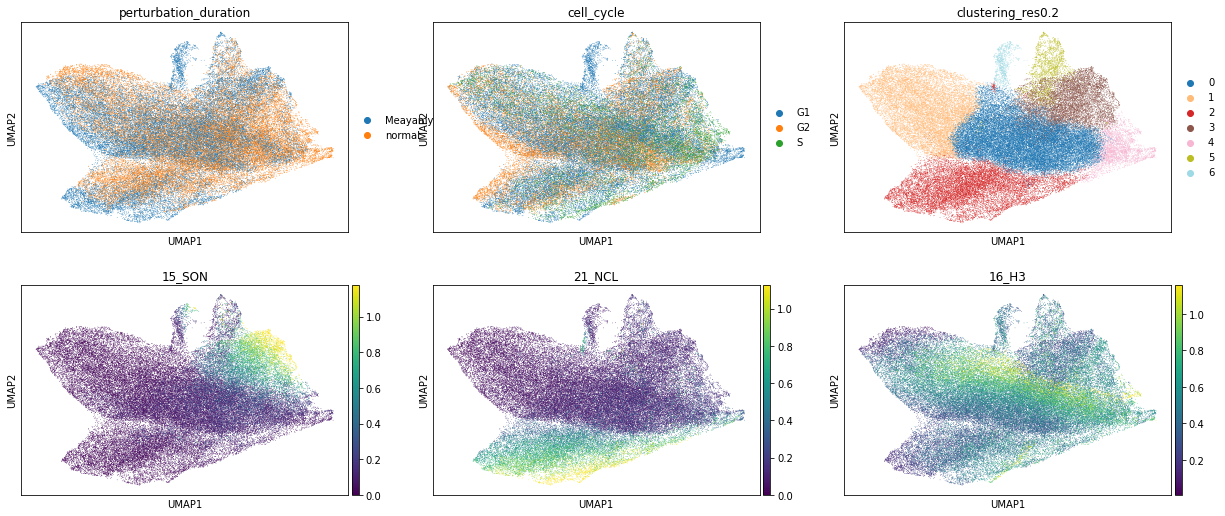

In [12]:
plt.rcParams["figure.figsize"] = [6, 4]
sc.pl.umap(
    adata,
    color=["perturbation_duration", "cell_cycle", "clustering_res0.2", "15_SON", "21_NCL", "16_H3"],
    vmax="p99",
    ncols=3,
)

To get an idea of what cellular compartments the channels correspond to, it is best to plot the mean intensity of each channel in each cluster:

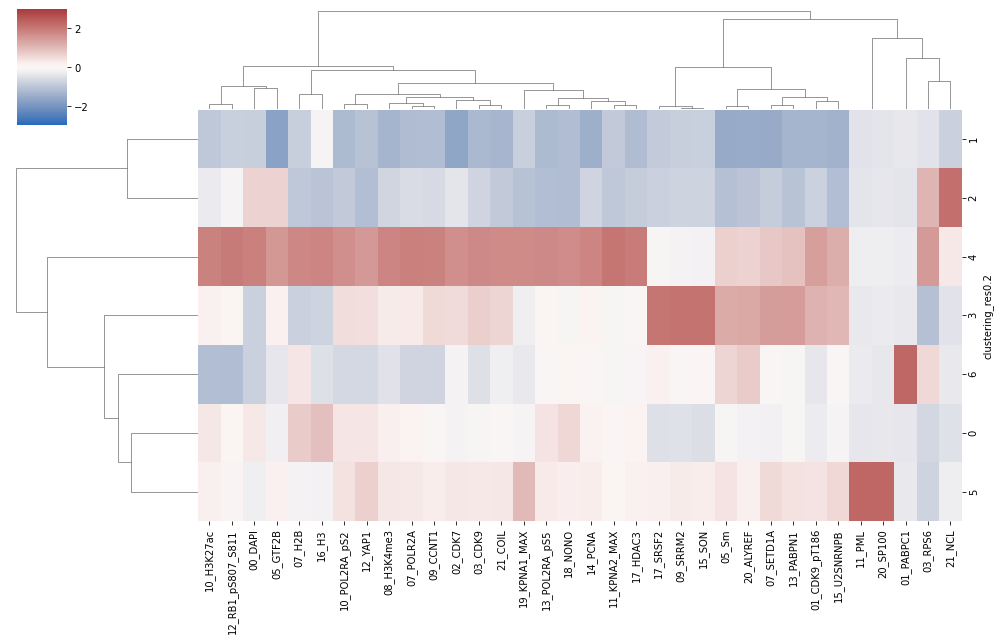

In [13]:
cluster_name = "clustering_res0.2"
pixel_values_annotated = pd.concat(
    [
        pd.DataFrame(adata.X, columns=adata.var_names).reset_index(drop=True),
        adata.obs[[cluster_name]].reset_index(drop=True),
    ],
    axis=1,
)
_ = sns.clustermap(
    pixel_values_annotated.groupby(cluster_name).aggregate("mean"),
    z_score=1,
    cmap="vlag",
    figsize=[14, 9],
    vmin=-3,
    vmax=3,
    method="ward",
)

It is also very useful to plot the clusters directly out over some example cells. Using [load_full_data_dict][] and [get_clustered_cells][], we can cluster some random cells from each well of the experiment.

[load_full_data_dict]: ../api/campa.tl.load_full_data_dict.rst
[get_clustered_cells]: ../api/campa.tl.get_clustered_cells.rst

In [14]:
# NOTE: this may take a couple of minutes
# load data
exp = Experiment.from_dir("test_pre_trained/CondVAE_pert-CC")
mpp_datas = load_full_data_dict(exp)
# project clustering to some example cells
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas, cl, "clustering_res0.2", num_objs=3))

184A1_unperturbed/I09
184A1_unperturbed/I11
184A1_meayamycin/I12
184A1_meayamycin/I20


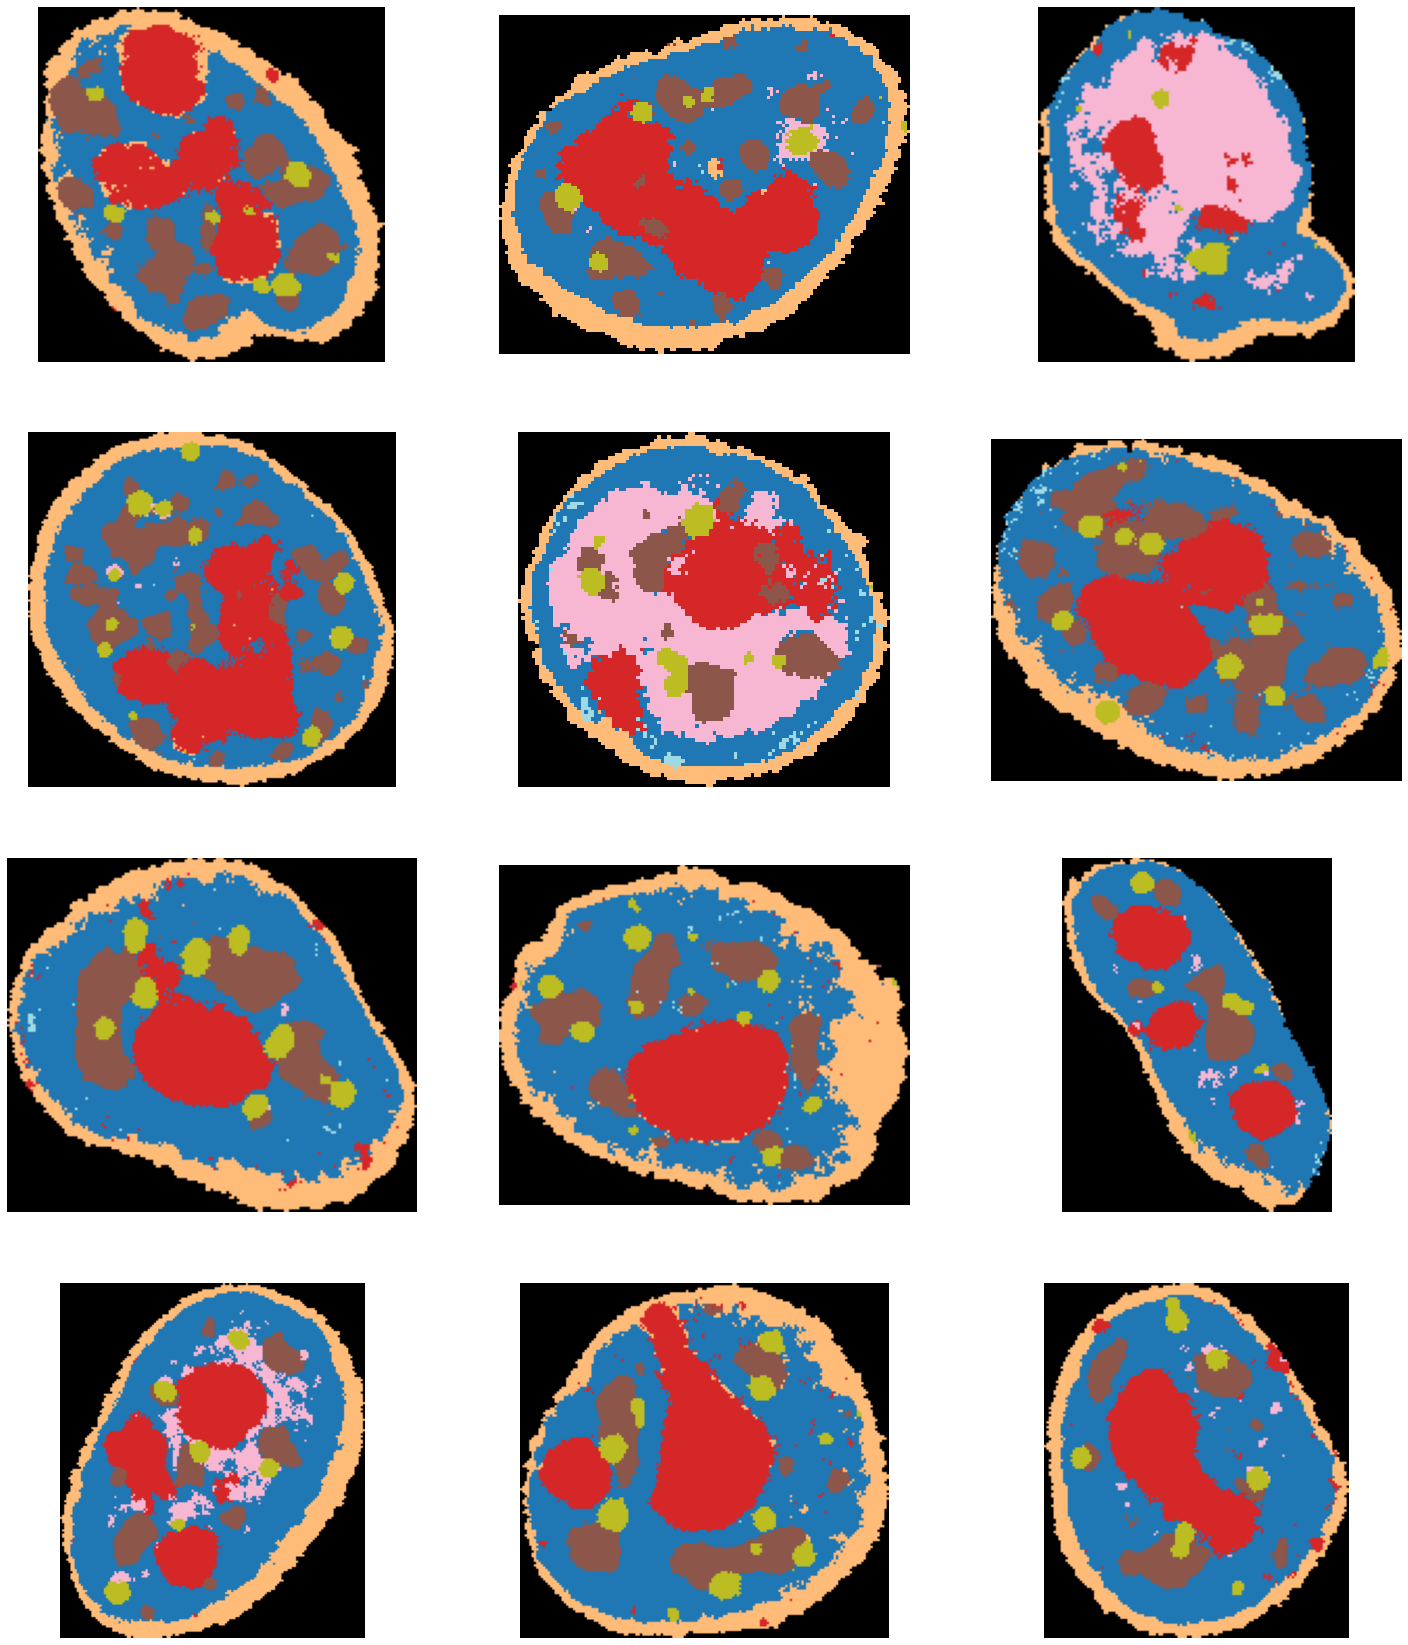

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(
    ["184A1_unperturbed/I09", "184A1_unperturbed/I11", "184A1_meayamycin/I12", "184A1_meayamycin/I20"]
):
    for i in range(3):
        axes[j, i].imshow(example_cells["clustering_res0.2_colored"][data_dir][i])

for ax in axes.flat:
    ax.axis("off")

### Annotate clustering
Now, we are ready to annotate the clustering with known structure names. Note that this annotation might vary slightly when rerunning this experiment and clustering, due to the inherent randomness of neural network training.

For the annotation, we will create a dictionary mapping leiden cluster names to annotated names, and use [Cluster.add_cluster_annotation][] to add the annotation to the [Cluster][] object. Annotations and colour maps for the annotations are stored in a csv file in the `cluster_data_dir`.

[add_cluster_annotation]: ../classes/campa.tl.Cluster.add_cluster_annotation.rst
[Cluster]: ../classes/campa.tl.Cluster.rst

In [16]:
annotation = {
    "0": "Nucleoplasm",
    "1": "Nuclear periphery",
    "2": "Nucleolus",
    "3": "Nuclear speckles",
    "4": "Nucleoplasm",
    "5": "PML bodies",
    "6": "Nucleoplasm",
}

cl.set_cluster_name("clustering_res0.2")
cl.add_cluster_annotation(annotation, "annotation")

The resulting cluster annotation data frame is stored in `cluster_data_dir/clustering_res0.2_annotation.csv`

In [17]:
# check out the resulting cluster annotation data frame - this is stored in cluster_data_dir/clustering_res0.2_annotation.csv
display(cl.cluster_annotation)
cluster_dir = os.path.join(campa_config.EXPERIMENT_DIR, cl.config["cluster_data_dir"])
print(cluster_dir)
print(os.listdir(cluster_dir))

,clustering_res0.2,clustering_res0.2_colors,annotation,annotation_colors
index,,,,
0,0,#1f77b4,Nucleoplasm,#c7c7c7
1,1,#ffbb78,Nuclear periphery,#1f77b4
2,2,#d62728,Nucleolus,#8c564b
3,3,#8c564b,Nuclear speckles,#98df8a
4,4,#f7b6d2,Nucleoplasm,#c7c7c7
5,5,#bcbd22,PML bodies,#9edae5
6,6,#9edae5,Nucleoplasm,#c7c7c7
7,,#ffffff,NaN,#ffffff


/Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre
['umap.npy', 'cluster_params.json', 'obj_ids.npy', '.DS_Store', 'clustering_res0.2.npy', 'clustering_res0.2_annotation.csv', 'labels.npy', 'pynndescent_index.pickle', 'mpp.npy', 'latent.npy', 'channels.csv', 'x.npy', 'metadata.csv', 'y.npy', 'conditions.npy']


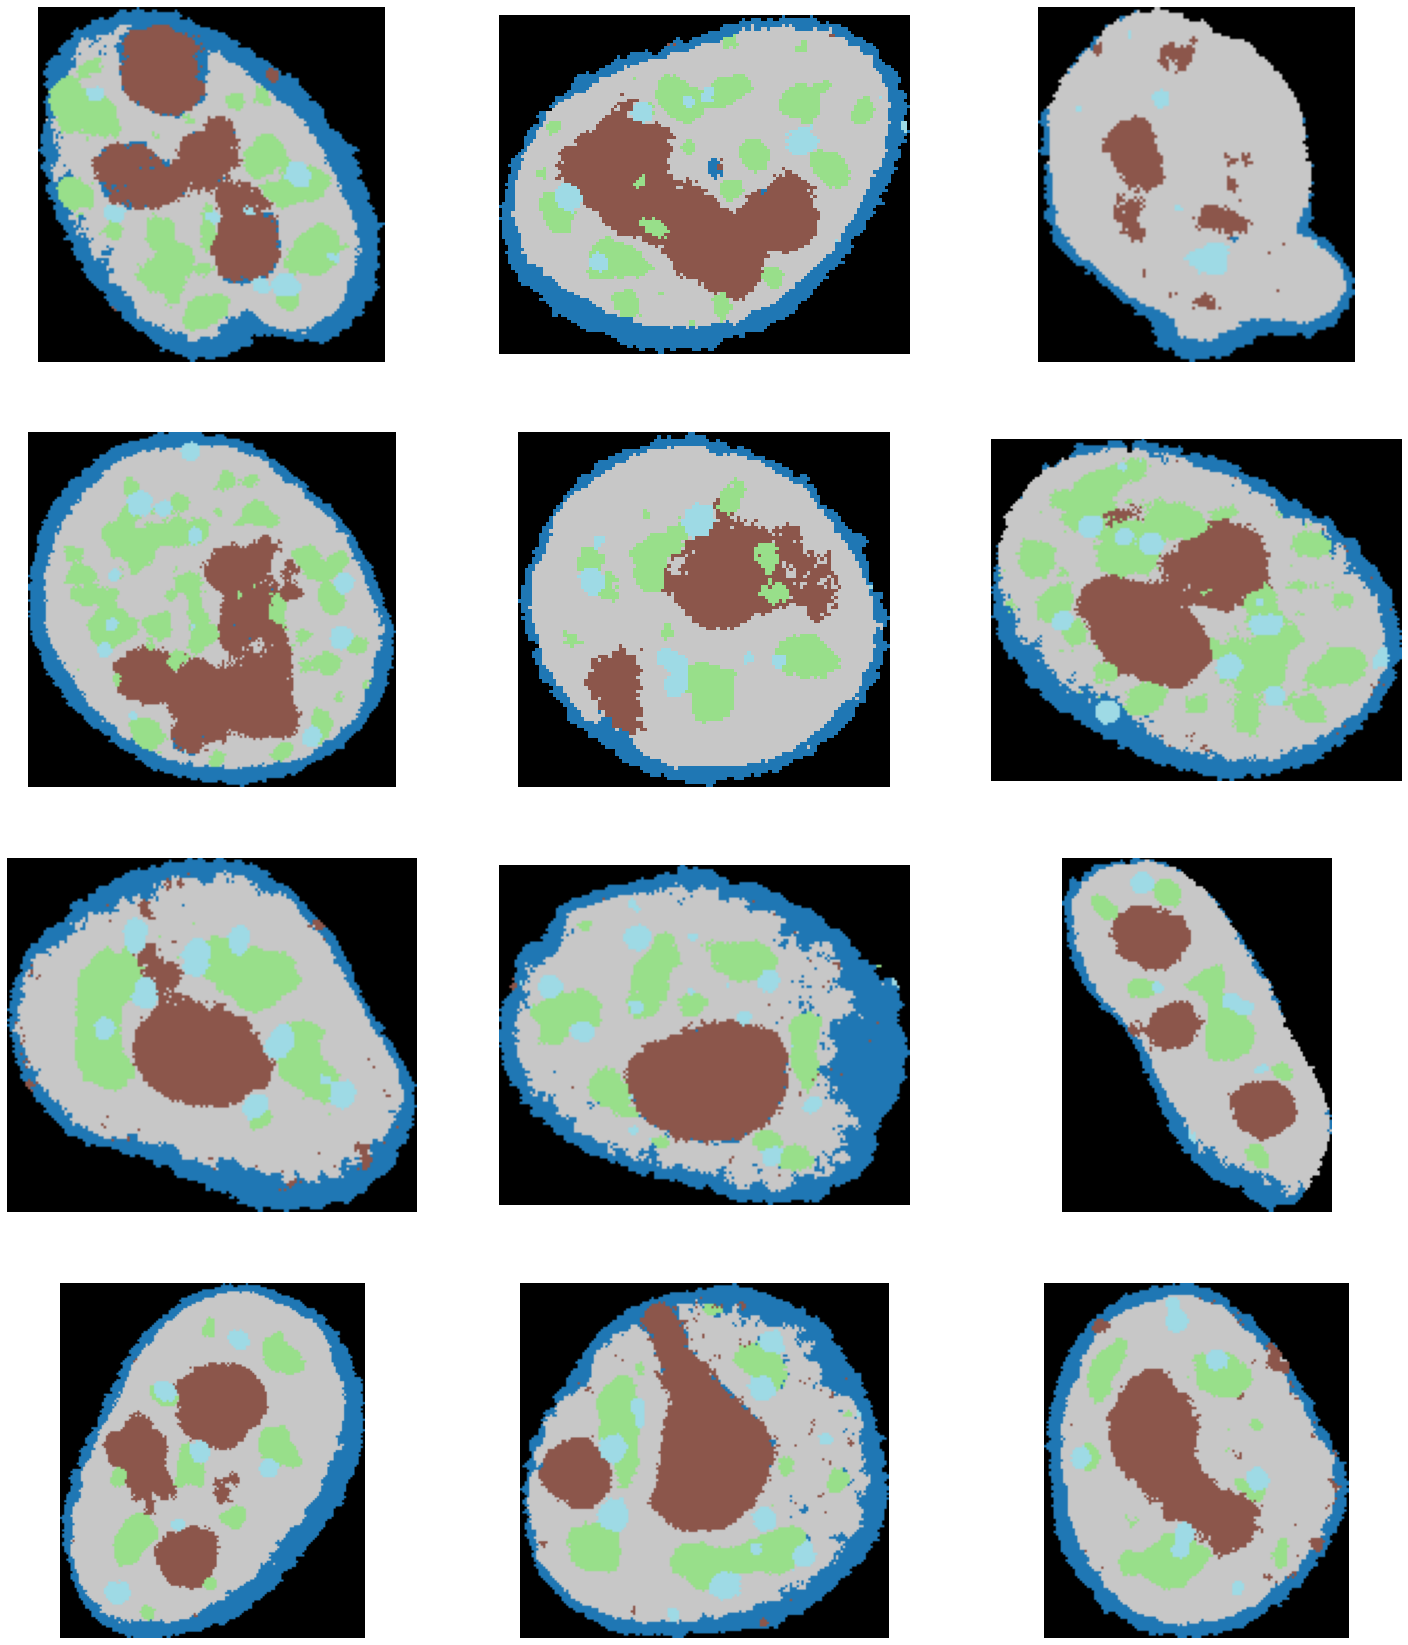

In [18]:
# check out cell colored by new annotation
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
for j, data_dir in enumerate(
    ["184A1_unperturbed/I09", "184A1_unperturbed/I11", "184A1_meayamycin/I12", "184A1_meayamycin/I20"]
):
    for i in range(3):
        axes[j, i].imshow(
            annotate_img(
                example_cells["clustering_res0.2"][data_dir][i],
                annotation=cl.cluster_annotation,
                from_col=cl.config["cluster_name"],
                to_col="annotation",
                color=True,
            )
        )

for ax in axes.flat:
    ax.axis("off")

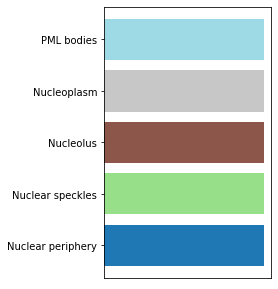

In [19]:
# legend
plt.rcParams["figure.figsize"] = [3, 5]
df = cl.cluster_annotation.groupby("annotation")["annotation_colors"].first()
plt.barh(y=range(len(df)), width=1, color=df)
_ = plt.yticks(range(len(df)), df.index, rotation=0)
_ = plt.xticks([])

## Predict model on full data
After generating a clustering on a subset of the data, we can now project it to the entire dataset. For this, the high-level API function [project_cluster_data][] can be used. Alternatively, the CLI can be used:
```
campa cluster test/CondVAE_pert-CC project aggregated/sub-pre --save-dir aggregated/full_data --cluster-name clustering_res0.2
```

[project_cluster_data]: ../api/campa.tl.project_cluster_data.rst

In [20]:
project_cluster_data(
    "test_pre_trained/CondVAE_pert-CC",
    cluster_data_dir="aggregated/sub-pre",
    cluster_name="clustering_res0.2",
    save_dir="aggregated/full_data",
)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/sub-pre/clustering_res0.2.npy


This creates `npy` files containing the clustering for the full data:

In [21]:
# check out the resulting clustering using one data_dir
full_data_dir = "test_pre_trained/CondVAE_pert-CC/aggregated/full_data"
mpp_data = MPPData.from_data_dir(
    os.path.join(campa_config.EXPERIMENT_DIR, full_data_dir, "184A1_unperturbed/I09"),
    data_config="ExampleData",
    keys=["clustering_res0.2"],
)
print("clustering:", mpp_data.data("clustering_res0.2"))

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/clustering_res0.2.npy
clustering: ['1' '1' '1' ... '1' '1' '1']


We are now ready to extract molecular, morphological, and size features from the CSLs. This is described in the [Extract features from CSLs tutorial](extract_features.ipynb).